This notebook can be used for making and visualizing the images of the XYZeq datasets. You can choose which stats and which color channels to map to which values of the sequencing data.

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import itertools as it

In [2]:
sc.settings.verbosity = 4

## 1. Read in Adata and Spatial Barcodes

In [3]:
prefix = '/data/xyzeq/'

In [4]:
adata = sc.read_h5ad(prefix + 'Spleen/spleen_all_batches_mouse_only_raw.h5ad')

In [5]:
batches_counts = pd.Series([(i, j) for i, j in zip(adata.obs_names.str[6:].str.split('_').str[0], adata.obs['batch'])]).value_counts()

In [6]:
batches_counts = batches_counts.loc[sorted(batches_counts.index, key=lambda x: x[1])]

In [7]:
batches_counts

(S10C, 0)      372
(S20C2, 1)    1547
(S20C1, 2)     818
(S15C, 3)      657
dtype: int64

In [8]:
spatial = pd.read_csv(prefix + 'xyzeq/plate23_map.csv', header=None, index_col=0)
spatial.columns = ['X','Y']

In [67]:
spatial.iloc[-20:,:]

,X,Y
0,,
CGCACTATAGGTTAAG,42,11
ATCGCGGTTCCTGAGG,42,12
AGTAGAGTTATCGTCC,42,13
GCTTGACCGTAATCGA,42,14
CGGCTCATTACTGCGG,42,15
GGACGCCTACAATGAT,42,16
TACATCGACGAACCTG,42,17
AGCGGAGAGTCAAGCT,42,18
GCATCCAATCGCGTTA,43,1


X indices 43 and 44 don't have a full set of Y indices. These indices are on the edge of the array and are complicating some of the operations further downstream. Because I've examined some of the outputs and they do not seem to be terribly useful anyway (probably contain very few cells), I'm going to drop them for now. I will do this after I add the columns to the `adata.obs`.

In [11]:
adata.obs['spatial_bc'] = [i.split('.')[1].split('-')[0] for i in adata.obs_names]

In [12]:
adata.obs['X'] = list(map(lambda x: spatial.loc[x,'X'], adata.obs['spatial_bc']))
adata.obs['Y'] = list(map(lambda x: spatial.loc[x,'Y'], adata.obs['spatial_bc']))

In [13]:
sum(adata.obs['X'] > 42)

0

In [14]:
adata_raw = sc.read_h5ad(prefix + 'Spleen/spleen.concat.raw_counts.h5ad')

In [15]:
adata_raw.shape

(7505, 52025)

In [16]:
adata.shape

(3394, 52025)

In [17]:
adata_raw = adata_raw[adata.obs_names].copy()

In [18]:
adata.obs['n_counts_sub'] = adata_raw.X.toarray().sum(axis=1)
adata.var['n_counts_sub'] = adata_raw.X.toarray().sum(axis=0)

In [19]:
adata.raw = adata_raw

In [20]:
mapper = dict(zip(adata.obs['CellType'].dtype.categories, adata.obs['CellType'].dtype.categories))
for ct in [i for i in adata.obs['CellType'].dtype.categories if i != 'mc38']:
    mapper[ct] = 'non_mc38'

## 1.1 No Hepatocytes — now what?

In our assay, we did not capture any stromal cell types in the spleen, so I'm going to make a separate CellType with MC38 and non-MC38.

In [21]:
adata.obs['prox_score_CellType'] = adata.obs['CellType'].map(mapper)

In [71]:
# adata.write_h5ad(prefix + 'Spleen/spleen.concat.adjustedXY.with_raw.h5ad')
adata = sc.read_h5ad(prefix + 'Spleen/spleen.concat.adjustedXY.with_raw.h5ad')

## 2. Get HexMap

In [22]:
myhex = np.zeros((12,12)) 

In [23]:
myhex[0:1,3:9] = 1
myhex[1:3,2:10] = 1
myhex[3:5,1:11] = 1
myhex[5:7,:12] = 1
myhex[7:9,1:11] = 1
myhex[9:11,2:10] = 1
myhex[11:12,3:9] = 1

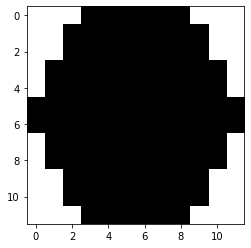

In [24]:
plt.imshow(myhex, cmap='binary');

In [25]:
# hex_coords.to_pickle(prefix + 'concatenated.deep/deep2/hex.coords.pkl')
hex_coords = pd.read_pickle(prefix + 'xyzeq/concatenated.deep/deep2/hex.coords.pkl')

## 3. Make Images

I've run the following on both the `CellType` and `prox_score_CellType`.

#### Build a Counts DataFrame

In [117]:
batches = adata.obs['batch'].values.unique()

In [118]:
celltype_string = 'prox_score_CellType'

In [119]:
celltypes = adata.obs[celltype_string].unique()

In [120]:
celltypes

array(['mc38', 'non_mc38'], dtype=object)

Initialize a counts dataframe that will contain the counts, per well and per batch, of each cell type. I'm going to use `pd.MultiIndex` to index according to `X`, `Y`, and `batch`. The MultiIndex, while useful, also causes some problems with by creating these indices of dtype `Category` that are hard to edit later. I try to remedy those issues by converting the columns to a regular index here, and then set the batch to an integer dtype after I build the counts dataframe. Converting to the batch to an integer is useful later.

In [121]:
counts = pd.DataFrame(0,index=pd.MultiIndex.from_product([batches,range(1,43),range(1,19)],names=['batch','X','Y']),columns=celltypes)
counts.columns = pd.Index(list(counts.columns)) # this is to convert the columns into a normal index and not a categorical index, not sure why it does that when using multiindex.from_product

In [122]:
counts.columns

Index(['mc38', 'non_mc38'], dtype='object')

Subset the adata into smaller adatas according to their batch.

In [123]:
adata_subs = dict()

In [124]:
for batch in batches:
    adata_subs[batch] = adata[adata.obs['batch'] == batch].copy()

Fill the counts dataframe.

In [125]:
for batch, x, y in tqdm(counts.index):
    xy_cts = adata_subs[batch][(adata_subs[batch].obs['X'] == x) & (adata_subs[batch].obs['Y'] == y)].obs[celltype_string]
    cts, ct_counts = np.unique(xy_cts.values, return_counts=True)
    for ct, ct_count in zip(cts, ct_counts):
        counts.loc[(batch, x, y),ct] = ct_count

This is where I convert the batch to an integer, it makes things easier later.

In [126]:
counts.index = counts.index.set_levels([counts.index.levels[0].astype(np.uint8), counts.index.levels[1], counts.index.levels[2]])

Going to run the above cells twice and pickle the values so I don't have to run in the future.

In [27]:
# counts.to_pickle(prefix + 'xyzeq/concatenated.deep/deep2/counts.spleen.CellType.pkl')
# counts = pd.read_pickle(prefix + 'xyzeq/concatenated.deep/deep2/counts.spleen.CellType.pkl')

# counts.to_pickle(prefix + 'xyzeq/concatenated.deep/deep2/counts.spleen.prox_score_CellType.pkl')
counts = pd.read_pickle(prefix + 'xyzeq/concatenated.deep/deep2/counts.spleen.prox_score_CellType.pkl')

#### Fill in the Hexarray with Color Values

In [28]:
def get_colors(df, cts, color=True, prop_den=None, clip_cts=None, clip_tots=None):
    '''
    This function takes in the counts of each cell type from the DataFrame and 
    will generate color values based on the proportion of cells in each well
    that are the celltype(s) of interest. If color set to False, will just
    return the actual proportion of each cell type not scaled to RGB values.
    
    cts is a list of celltypes.
    
    For calculating proportion, will use a denomintaor of the total of only the provided 
    cell types (prop_den='cts') or the total of all cells (prop_den='tot'). If not
    provided, for len(ct) == 1 will set to 'tot', else will use 'cts'.
    
    `clip_cts` (list, same length as cts) will floor counts to zero before doing
    proportion calculations. `clip_tots` (int) will floor color values to zero
    of wells that don't contain at least that many cells.
    
    Plotting raw counts is kind of unmeaningful, so skipping that for now.
    '''
    assert type(cts) == type(list())
    
    if type(clip_cts) == type(None):
        clip_cts = [0]*len(cts)
    else:
        assert len(clip_cts) == len(cts)

    if type(prop_den) == type(None):
        # will fill in with what I think is appropriate if not provided
        if len(cts) == 1:
            prop_den = 'tot'
        else:
            prop_den = 'cts'
            
    # actually get the denominator
    if prop_den == 'cts':
        prop_den_vals = df[cts].sum(axis=1).values
    elif prop_den == 'tot':
        prop_den_vals = df.sum(axis=1).values
    else:
        raise ValueError

    
    val_dict = dict() 
    val_arrs = [np.zeros((len(df),))]*3 
    
    for i in range(len(cts)):
        ct = cts[i]
        val_dict[ct] = df[ct].values
        clip_val = clip_cts[i]
        val_dict[ct] = np.where(val_dict[ct] < clip_val, 0, val_dict[ct])
        with np.errstate(invalid='ignore'):
            val_dict[ct] = val_dict[ct] / prop_den_vals # this produces Nans, but they get replaced with 0 when converting to np.uint8
        val_arrs[i] = val_dict[ct]
        
    if color == True:
        colors = [255*i for i in val_arrs]
        colors = np.stack(colors, axis=1).astype(np.uint8)
        val_df = pd.DataFrame(colors,index=df.index,columns=['r','g','b'])
    else:
        props = np.nan_to_num(np.stack(val_arrs[:len(cts)], axis=1))
        val_df = pd.DataFrame(props, index=df.index, columns=['%' + '%s/%s' % (ct, prop_den) for ct in cts])
    
    if type(clip_tots) != type(None):
        tot = df.sum(axis=1).values
        clip_tot_mask = tot >= clip_tots
        clip_tot_mask = np.array([clip_tot_mask]*3).astype(bool).T
        val_df.where(clip_tot_mask,0,inplace=True)
                              
#     val_df = val_df[val_df.sum(axis=1) != 0] # do not include this, just fill the whole thing, I thought to include it to reduce time but it causes problems later

    return val_df

In [38]:
def get_image(color_df):
    '''
    color_df is a dataframe with columns 'r', 'g', and 'b', corresponding to the color values
    that should be filled into each hexagon.
    '''
    img = list()
    for color in ['r','g','b']:
        hex_array = np.zeros((222,399))
        for y, x in it.product(range(1,19),range(1,45)):

            try:
                val = color_df.loc[(x, y), color]
            except: # I should make this exception more specific
                continue

            xstart = hex_coords.loc[(x,y),'hex_xstart']
            ystart = hex_coords.loc[(x,y),'hex_ystart']

            yend = hex_coords.loc[(x,y),'hex_yend']
            xend = hex_coords.loc[(x,y),'hex_xend']

            current_hex = hex_array[ystart:yend,xstart:xend]
            hex_array[ystart:yend,xstart:xend] = np.where(myhex, val, current_hex)
        img.append(hex_array)
    img = np.stack(img, axis=2).astype(np.uint8)
    return img

In [64]:
def add_random_gray_background(color_df):
    for y, x in it.product(range(1,19),range(1,45)):
        try:
            if color_df.loc[(x, y)].sum() == 0:
                color_df.loc[(x, y)] = np.random.randint(50, 100)
        except:
            continue
    return color_df

First, just color by total count:

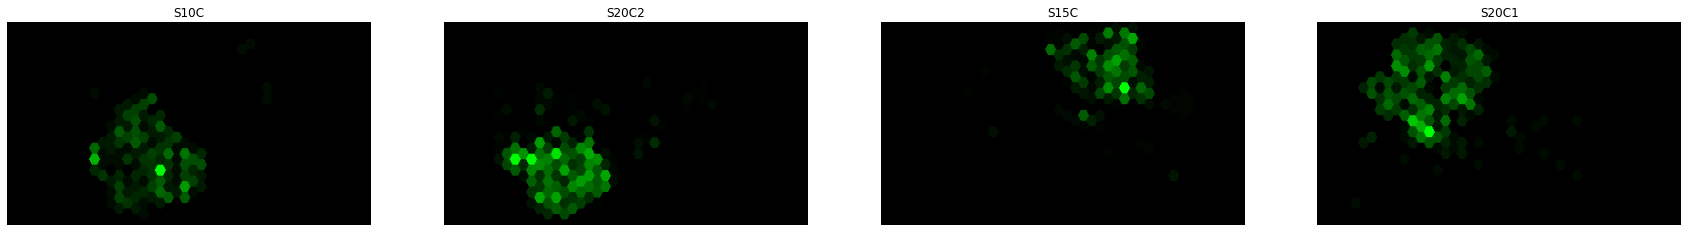

In [57]:
img_list = list()
for batch in tqdm(counts.index.get_level_values('batch').unique()):
    color_df = pd.DataFrame(0, index = counts.loc[batch].index, columns = ['r','g','b'])
    tot = counts.loc[batch].sum(axis=1)
    tot = np.uint8(tot/tot.max()*255)
    color_df['g'] = tot
    img = get_image(color_df)
    img_list.append(img)
fig, axes = plt.subplots(1,4, figsize=(30,10))
for img, ax, title in zip(img_list, np.ravel(axes), ['S10C', 'S20C2', 'S15C', 'S20C1']):
    ax.imshow(img);
    ax.set_title(title)
    ax.axis('off')

Next, color by %Hepatocyte vs %Cancer:

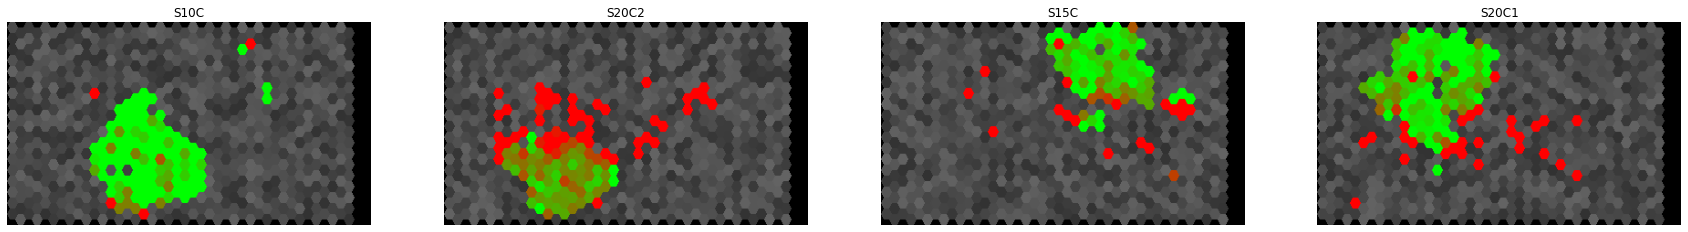

In [65]:
img_list = list()
for batch in tqdm(counts.index.get_level_values('batch').unique()):
    images = list()
    color_df = get_colors(counts.loc[batch], cts=['non_mc38', 'mc38'])
    color_df = add_random_gray_background(color_df)
    img = get_image(color_df)
    img_list.append(img)
fig, axes = plt.subplots(1,4, figsize=(30,10))
for img, ax, title in zip(img_list, np.ravel(axes), ['S10C', 'S20C2', 'S15C', 'S20C1']):
    ax.imshow(img);
    ax.set_title(title)
    ax.axis('off')